<a href="https://colab.research.google.com/github/deba8612/Summer-Project-Physics-informed-Learning/blob/main/Results_a%3D1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install deepxde
import re

import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from scipy.integrate import odeint
from matplotlib import cm
import scipy.io

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.3/165.3 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 10.6 MB/s eta 0:00:00
No backend selected.
Finding available backend...


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


In [ ]:
#Safety PDE with Data
import scipy.io

mat1 = scipy.io.loadmat('/content/drive/My Drive/PIPE-L4DC/MC data/f(x) = 1/a=1/GroundTruth_a1.mat')
mat2 = scipy.io.loadmat('/content/drive/My Drive/PIPE-L4DC/MC data/f(x) = 1/a=1/MC100_a1.mat')
mat3 = scipy.io.loadmat('/content/drive/My Drive/PIPE-L4DC/MC data/f(x) = 1/a=1/MC_a1.mat')
mat4 = scipy.io.loadmat('/content/drive/My Drive/PIPE-L4DC/MC data/f(x) = 1/a=1/MC10000_a1.mat')
mat5 = scipy.io.loadmat('/content/drive/My Drive/PIPE-L4DC/MC data/f(x) = 1/a=1/MC10_a1.mat')
safety_pde_a1 = mat1['F2']
safety_pde_a1.shape # (105, 10000)
MC100_a1 = mat2['U2']
MC_a1 = mat3['U2']
MC10000_a1 = mat4['U2']
MC10_a1 = mat5['U2']
MC_a1.shape # (105, 10000)
safety_pde_a1[46:105, ::100].shape # (59, 100)

safety_pde_a1 = safety_pde_a1[46:105, ::100]
MC10_a1 = MC10_a1[46:105, ::100]
MC100_a1 = MC100_a1[46:105, ::100]
MC_a1 = MC_a1[46:105, ::100]
MC10000_a1 = MC10000_a1[46:105, ::100]


bnd = np.ones([1,100])
bnd.shape # (1, 100)
safety_pde_a1 = np.append(safety_pde_a1, bnd, axis=0)
MC10_a1 = np.append(MC10_a1, bnd, axis=0)
MC100_a1 = np.append(MC100_a1, bnd, axis=0)
MC_a1 = np.append(MC_a1, bnd, axis=0)
MC10000_a1 = np.append(MC10000_a1, bnd, axis=0)


MC_a1.shape # (60, 100)

(60, 100)

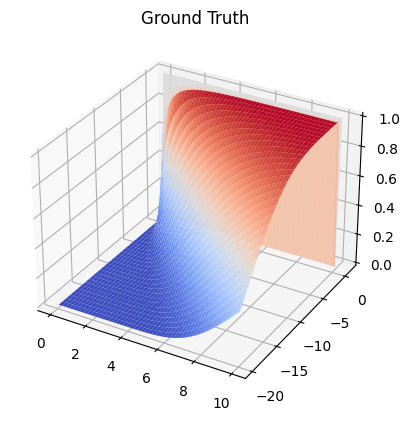

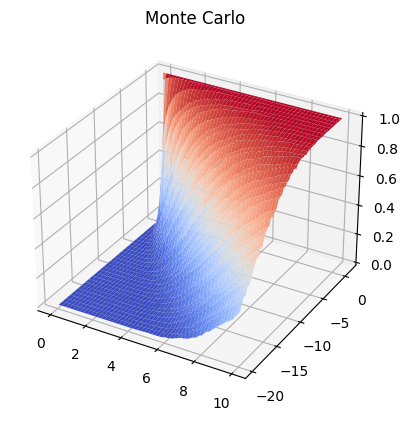

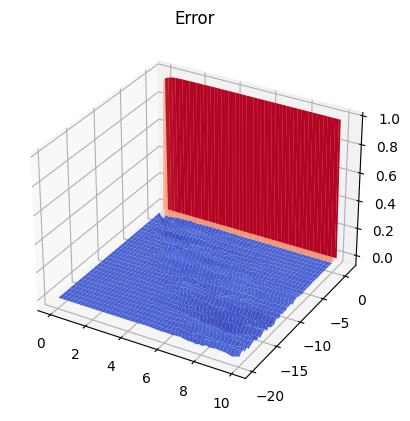

In [ ]:
x = np.linspace(0,10,100)
y = np.linspace(-19.8,1,60)

X, Y = np.meshgrid(x, y)

hf = plt.figure()
ha = hf.add_subplot(111, projection='3d')

ha.plot_surface(X, Y, safety_pde_a1, cmap=cm.coolwarm) # X: time, Y: state

plt.title('Ground Truth')

hf = plt.figure()
ha = hf.add_subplot(111, projection='3d')

ha.plot_surface(X, Y, MC_a1, cmap=cm.coolwarm) # X: time, Y: state

plt.title('Monte Carlo')

hf = plt.figure()
ha = hf.add_subplot(111, projection='3d')

ha.plot_surface(X, Y, MC_a1 - safety_pde_a1, cmap=cm.coolwarm) # X: time, Y: state

plt.title('Error')

plt.show()

In [ ]:
#Resampling For Generation
MC_sub = MC10000_a1[::2,::5][0:20,:] # sub-sampling as training data
MC_sub.shape # (20, 20)

observe_x_data = np.mgrid[-19.8:-2:0.9, 0.1:10:0.5].reshape(2,-1).T
observe_x_data.shape # (400, 2)

observe_func_data = MC_sub.reshape(-1,1)

In [ ]:
observe_x_data.shape

(400, 2)

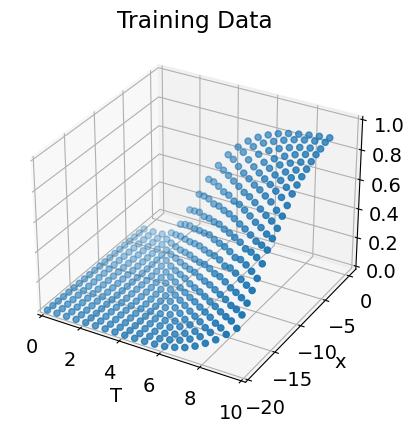

In [ ]:
x = np.linspace(0.1,9.6,20)
y = np.arange(-19.8, -2, 0.9)

X, Y = np.meshgrid(x, y)

import matplotlib
matplotlib.rcParams.update({'font.size': 14})

hf = plt.figure()
ha = hf.add_subplot(111, projection='3d')
ha.scatter(X, Y, MC_sub) # X: time, Y: state
ha.set_xlim(0, 10)
ha.set_ylim(-20,1 )
ha.set_zlim(0, 1)
ha.set_xlabel('T')
ha.set_ylabel('x')
ha.set_title("Training Data")
plt.show()

In [ ]:
bc = np.mgrid[2:2.1:1, 0.1:10:0.5].reshape(2,-1).T
ic = np.mgrid[-19.6:0.7:0.725, 0:0.1:1].reshape(2,-1).T
bc.shape # (20, 2)
ic.shape # (29, 2)
bc_func = np.ones([20,1])
ic_func = np.zeros([29,1])

observe_x_temp = np.append(observe_x_data, bc, axis=0)
observe_x_temp
observe_x = np.append(observe_x_temp, ic, axis=0)
observe_x

observe_func_temp = np.append(observe_func_data, bc_func, axis=0)
observe_func_temp
observe_func = np.append(observe_func_temp, ic_func, axis=0)
# observe_func

In [ ]:
ic.shape

(29, 2)

In [ ]:
#Fixed PDE

def pde(x, y):
    dy_t = dde.grad.jacobian(y, x, j=1)
    dy_x = dde.grad.jacobian(y, x, j=0)
    dy_xx = dde.grad.hessian(y, x, j=0)
    # Backend tensorflow.compat.v1 or tensorflow
    return (
        dy_t
        - 0.5 * dy_xx
        - 1 * dy_x
    )

In [ ]:
observe_y = dde.icbc.PointSetBC(observe_x, observe_func, component=0)
geom = dde.geometry.Interval(-19.8, 1)
timedomain = dde.geometry.TimeDomain(0, 10)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

data = dde.data.TimePDE(
   geomtime,
   pde,
   [observe_y],
   num_domain=200,
   # num_boundary=20,
   # num_initial=10,
   anchors=observe_x,
)

In [ ]:
layer_size = [2] + [32] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)

model.compile(
    "adam", lr=0.001, external_trainable_variables=[]
)
variable = dde.callbacks.VariableValue([], period=1000)
model.train(epochs=60000, callbacks=[variable])

Compiling model...
Building feed-forward neural network...
'build' took 0.073335 s

'compile' took 0.560293 s

Training model...

Step      Train loss              Test loss               Test metric
0         [4.45e-03, 5.83e-02]    [4.45e-03, 5.83e-02]    []  
0 []
1000      [1.98e-03, 4.86e-04]    [1.98e-03, 4.86e-04]    []  
1000 []
2000      [1.92e-03, 4.03e-04]    [1.92e-03, 4.03e-04]    []  
2000 []
3000      [1.87e-03, 3.68e-04]    [1.87e-03, 3.68e-04]    []  
3000 []
4000      [1.85e-03, 3.63e-04]    [1.85e-03, 3.63e-04]    []  
4000 []
5000      [1.84e-03, 3.62e-04]    [1.84e-03, 3.62e-04]    []  
5000 []
6000      [1.83e-03, 3.63e-04]    [1.83e-03, 3.63e-04]    []  
6000 []
7000      [1.82e-03, 3.63e-04]    [1.82e-03, 3.63e-04]    []  
7000 []
8000      [1.90e-03, 9.28e-04]    [1.90e-03, 9.28e-04]    []  
8000 []
9000      [1.82e-03, 3.53e-04]    [1.82e-03, 3.53e-04]    []  
9000 []
10000     [1.81e-03, 3.57e-04]    [1.81e-03, 3.57e-04]    []  
10000 []
11000     [1.80e-03, 

(<deepxde.model.LossHistory at 0x7c457ecf3d90>,
 <deepxde.model.TrainState at 0x7c457ecf3b80>)

In [ ]:
test_x = np.mgrid[-19.7:1.3:0.355, 0.1:10.1:0.1].reshape(2,-1).T
test_x.shape # (6000, 2)
test_y = safety_pde_a1.reshape(-1,1)
test_y.shape # (6000, 1)

yhat = model.predict(test_x)

yhat.shape # (6000, 1)

safety_predict = yhat.reshape(60,-1)
safety_predict

array([[3.0792505e-04, 3.8010627e-04, 4.4912845e-04, ..., 2.4401131e-01,
        2.5285041e-01, 2.6357570e-01],
       [3.5477430e-04, 4.2784959e-04, 4.9776584e-04, ..., 2.6576710e-01,
        2.7887890e-01, 2.9340813e-01],
       [4.0090829e-04, 4.7475845e-04, 5.4515153e-04, ..., 2.9586199e-01,
        3.1191513e-01, 3.2587749e-01],
       ...,
       [6.8354197e-02, 1.3043380e-01, 1.6898721e-01, ..., 9.9754941e-01,
        9.9747324e-01, 9.9739391e-01],
       [1.6880012e-01, 3.9340457e-01, 6.5118897e-01, ..., 9.9737006e-01,
        9.9727565e-01, 9.9717820e-01],
       [8.2421368e-01, 9.0458018e-01, 9.4963789e-01, ..., 9.9700463e-01,
        9.9690324e-01, 9.9679917e-01]], dtype=float32)

In [ ]:
test_x.shape


(6000, 2)

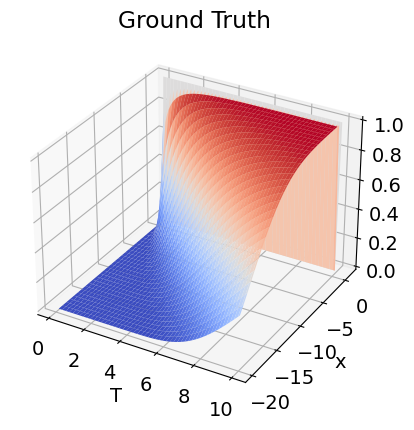

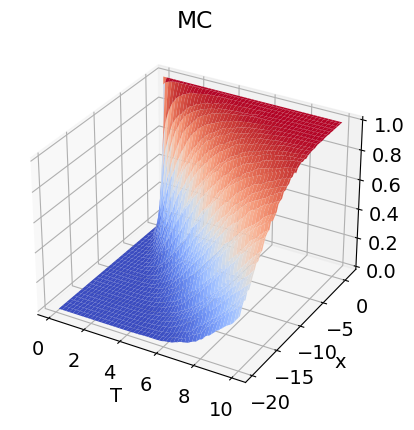

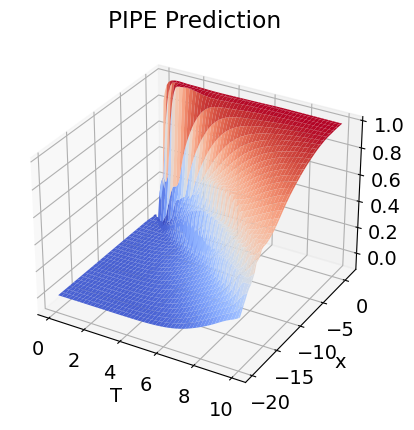

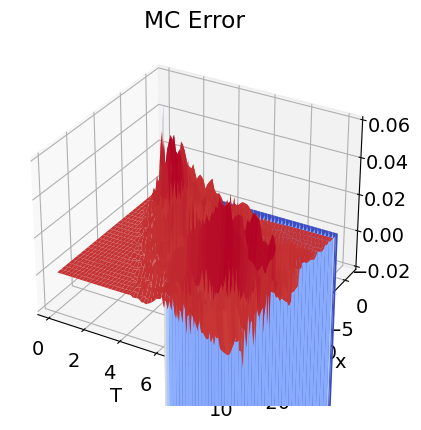

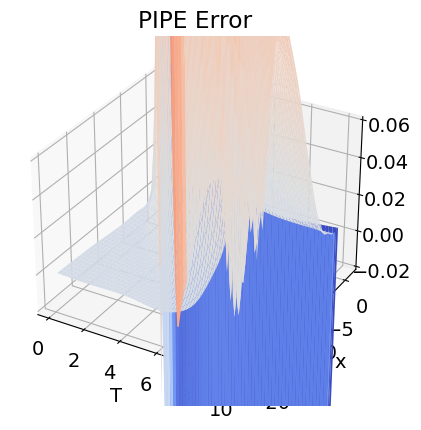

In [ ]:
x = np.linspace(0.1,10,100)
y = np.linspace(-19.8,1,60)

X, Y = np.meshgrid(x, y)

hf = plt.figure()
ha = hf.add_subplot(111, projection='3d')
ha.plot_surface(X, Y, safety_pde_a1, cmap=cm.coolwarm) # X: time, Y: state
ha.set_xlabel('T')
ha.set_ylabel('x')
ha.set_title("Ground Truth")

hf = plt.figure()
ha = hf.add_subplot(111, projection='3d')
ha.plot_surface(X, Y, MC_a1, cmap=cm.coolwarm) # X: time, Y: state
ha.set_xlabel('T')
ha.set_ylabel('x')
ha.set_title("MC")

hf = plt.figure()
ha = hf.add_subplot(111, projection='3d')
ha.plot_surface(X, Y, safety_predict, cmap=cm.coolwarm) # X: time, Y: state
ha.set_xlabel('T')
ha.set_ylabel('x')
ha.set_title("PIPE Prediction")

hf = plt.figure()
ha = hf.add_subplot(111, projection='3d')
ha.set_zlim(-0.02, 0.06)
ha.plot_surface(X, Y, safety_pde_a1 - MC_a1, cmap=cm.coolwarm) # X: time, Y: state
ha.set_xlabel('T')
ha.set_ylabel('x')
ha.set_title("MC Error")

hf = plt.figure()
ha = hf.add_subplot(111, projection='3d')
ha.set_zlim(-0.02, 0.06)
ha.plot_surface(X, Y, safety_pde_a1-safety_predict, cmap=cm.coolwarm) # X: time, Y: state
ha.set_xlabel('T')
ha.set_ylabel('x')
ha.set_title("PIPE Error")
plt.show()

In [ ]:
mat6 = scipy.io.loadmat('/content/drive/My Drive/PIPE-L4DC/MC data/fitting/poly55.mat')
mat7 = scipy.io.loadmat('/content/drive/My Drive/PIPE-L4DC/MC data/fitting/lowess.mat')
mat8 = scipy.io.loadmat('/content/drive/My Drive/PIPE-L4DC/MC data/fitting/cubic_spline.mat')
mat9 = scipy.io.loadmat('/content/drive/My Drive/PIPE-L4DC/MC data/fitting/biharmonic.mat')
mat0 = scipy.io.loadmat('/content/drive/My Drive/PIPE-L4DC/MC data/fitting/tps.mat')
poly55 = mat6['U_fit']
lowess = mat7['U_fit']
cubic = mat8['U_fit']
biharmonic = mat9['U_fit']
tps = mat0['U_fit']
cubic_num = np.nan_to_num(cubic)
poly55.shape # (60, 100)

(60, 100)

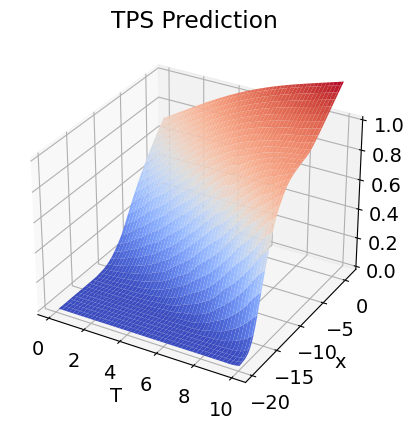

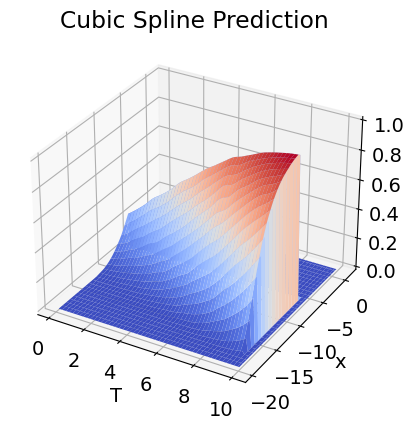

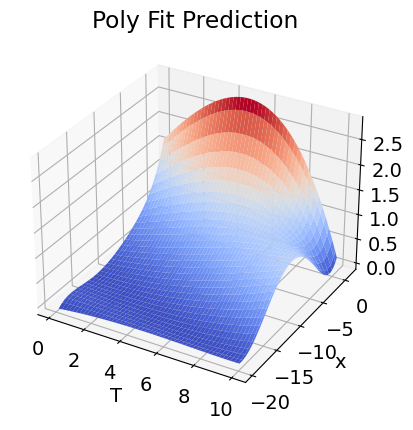

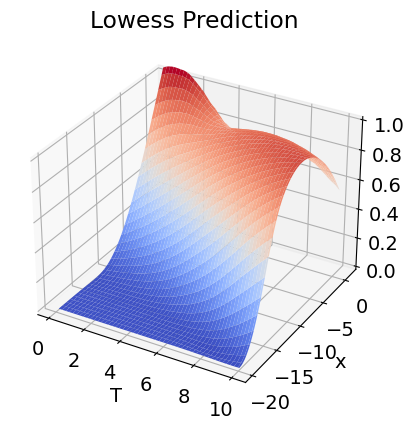

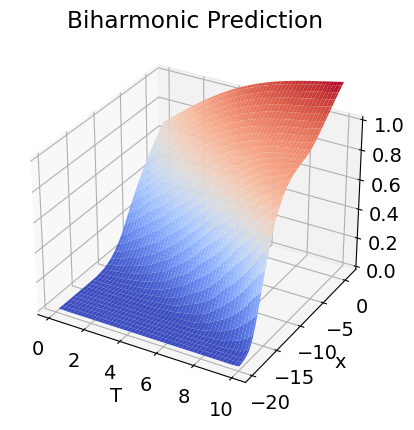

In [ ]:
x = np.linspace(0.1,10,100)
y = np.linspace(-19.8,1,60)

X, Y = np.meshgrid(x, y)

hf = plt.figure()
ha = hf.add_subplot(111, projection='3d')
ha.plot_surface(X, Y, tps, cmap=cm.coolwarm) # X: time, Y: state
ha.set_title("TPS Prediction")
ha.set_xlabel('T')
ha.set_ylabel('x')
ha.set_zlim(0, 1)

x = np.linspace(0.1,10,100)
y = np.linspace(-19.8,1,60)

X, Y = np.meshgrid(x, y)

hf = plt.figure()
ha = hf.add_subplot(111, projection='3d')
ha.plot_surface(X, Y, cubic_num, cmap=cm.coolwarm) # X: time, Y: state
ha.set_title("Cubic Spline Prediction")
ha.set_xlabel('T')
ha.set_ylabel('x')
ha.set_zlim(0, 1)

hf = plt.figure()
ha = hf.add_subplot(111, projection='3d')
ha.plot_surface(X, Y, poly55, cmap=cm.coolwarm) # X: time, Y: state
ha.set_title("Poly Fit Prediction")
ha.set_xlabel('T')
ha.set_ylabel('x')

hf = plt.figure()
ha = hf.add_subplot(111, projection='3d')
ha.plot_surface(X, Y, lowess, cmap=cm.coolwarm) # X: time, Y: state
ha.set_title("Lowess Prediction")
ha.set_xlabel('T')
ha.set_ylabel('x')
ha.set_zlim(0, 1)

hf = plt.figure()
ha = hf.add_subplot(111, projection='3d')
ha.plot_surface(X, Y, biharmonic, cmap=cm.coolwarm) # X: time, Y: state
ha.set_title("Biharmonic Prediction")
ha.set_xlabel('T')
ha.set_ylabel('x')
ha.set_zlim(0, 1)

plt.show()

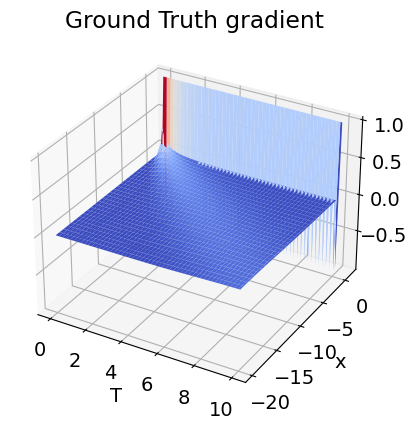

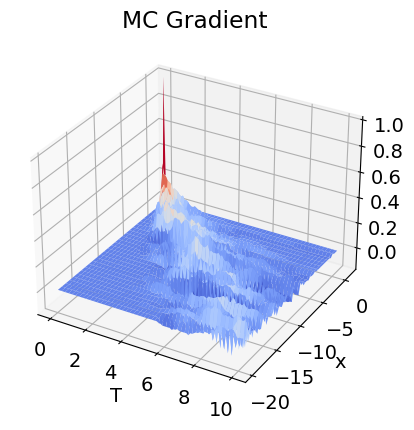

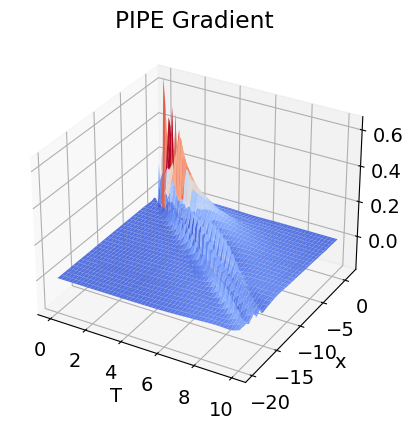

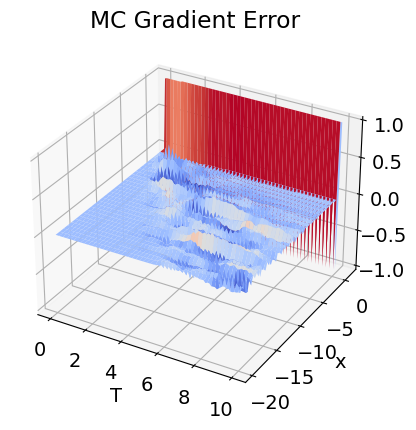

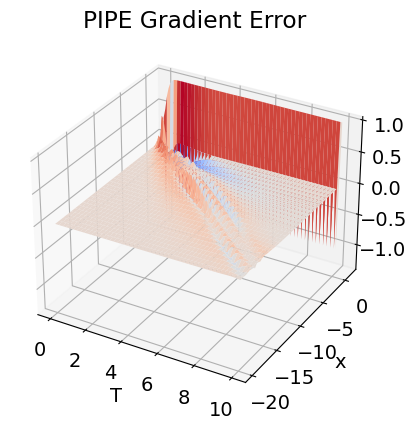

In [ ]:
GT_grad = np.diff(safety_pde_a1, axis=0) # gradient of state dF/dx
MC_grad = np.diff(MC100_a1, axis=0)
PINN_grad = np.diff(safety_predict, axis=0)

x = np.linspace(0,10,100)
y = np.linspace(-19.8,1,59)

X, Y = np.meshgrid(x, y)

hf = plt.figure()
ha = hf.add_subplot(111, projection='3d')
ha.plot_surface(X, Y, GT_grad, cmap=cm.coolwarm) # X: time, Y: state
ha.set_xlabel('T')
ha.set_ylabel('x')
ha.set_title("Ground Truth gradient")

hf = plt.figure()
ha = hf.add_subplot(111, projection='3d')
ha.plot_surface(X, Y, MC_grad, cmap=cm.coolwarm) # X: time, Y: state
ha.set_xlabel('T')
ha.set_ylabel('x')
ha.set_title("MC Gradient")

hf = plt.figure()
ha = hf.add_subplot(111, projection='3d')
ha.plot_surface(X, Y, PINN_grad, cmap=cm.coolwarm) # X: time, Y: state
ha.set_xlabel('T')
ha.set_ylabel('x')
ha.set_title("PIPE Gradient")

hf = plt.figure()
ha = hf.add_subplot(111, projection='3d')
ha.plot_surface(X, Y, GT_grad - MC_grad, cmap=cm.coolwarm) # X: time, Y: state
ha.set_xlabel('T')
ha.set_ylabel('x')
ha.set_title("MC Gradient Error")

hf = plt.figure()
ha = hf.add_subplot(111, projection='3d')
ha.plot_surface(X, Y, GT_grad - PINN_grad, cmap=cm.coolwarm) # X: time, Y: state
ha.set_xlabel('T')
ha.set_ylabel('x')
ha.set_title("PIPE Gradient Error")
plt.show()

In [ ]:
error_NN = safety_pde_a1-safety_predict
print(np.average(abs(error_NN))) # 0.003382234932241756
error_fit = safety_pde_a1-tps
np.average(abs(error_fit)) # 0.09245016818251624
gradient_error_NN = GT_grad - PINN_grad
np.average(abs(gradient_error_NN)) # 0.0006199242829057887
# gradient_error_MC = GT_grad - MC_grad
# np.average(abs(gradient_error_MC)) # 0.027838523319294633

0.10487286076707433


0.049022640167156864